In [1]:
using Yao,Yao.Blocks,Yao.Interfaces,Yao.Registers,Yao.Intrinsics;
using PyPlot;
using LinearAlgebra;
using DataFrames;
using Random;
using JLD;
# using Plots;
using Statistics;
using CSV;

In [33]:
stryatemp=[1 0 0 0;0 (1-1.0im)/2 (1+1.0im)/2 0;0 (1+1.0im)/2 (1-1.0im)/2 0;0 0 0 1]
# stryatemp*stryatemp*stryatemp*stryatemp

@const_gate ownphasegate::ComplexF64=[1 0 0 0;0 1 0 0;0 0 -1im 0;0 0 0 1];
@const_gate sqrtswap::ComplexF64=[1 0 0 0;0 (1-1.0im)/2 (1+1.0im)/2 0;0 (1+1.0im)/2 (1-1.0im)/2 0;0 0 0 1];
@const_gate sqrtswapdag::ComplexF64=[1 0 0 0; 0 0.5+0.5im 0.5-0.5im 0; 0.0 0.5-0.5im 0.5+0.5im 0.0; 0.0 0.0 0 1];

In [34]:
seq=chain(10,put(10,(1,2)=>sqrtswap),put(10,(3,4)=>sqrtswap),put(10,(5,6)=>sqrtswap),
    put(10,(7,8)=>sqrtswap),put(10,(9,10)=>sqrtswap),
    
    put(10,(1,2)=>ownphasegate),put(10,(3,4)=>ownphasegate),put(10,(5,6)=>ownphasegate),
    put(10,(7,8)=>ownphasegate),put(10,(9,10)=>ownphasegate),
    
    put(10,(2,3)=>sqrtswap),put(10,(4,5)=>sqrtswap),put(10,(6,7)=>sqrtswap),put(10,(8,9)=>sqrtswap))

reg1times10=product_state(10,0b0101010101)
# @show reg.state
apply!(reg1times10,seq)

DefaultRegister{1, Array{Complex{Float64},2}}
    active qubits: 10/10

In [35]:
usefulposition=[]

for i in 1:(2^10-1)
    position=tuple(baddrs(i)...)
    reg=copy(reg1times10)
    tracestate=reg |> focus!(position...)|> ρ
    relax!(reg,position)
    gx=fill(X,length(position))
    gy=fill(Y,length(position))
    gz=fill(Z,length(position))
    tmp=[expect(KronBlock(gx...),tracestate),expect(KronBlock(gy...),tracestate),
        expect(KronBlock(gz...),tracestate)]
    if sum(real.(abs.(tmp)))>1
        println(position,",",tmp)
        append!(usefulposition,i)
    end
end

(1, 2),Complex{Float64}[0.5+0.0im, 0.5+0.0im, -0.5+0.0im]
(1, 3),Complex{Float64}[0.5+0.0im, 0.5+0.0im, -0.5+0.0im]
(1, 2, 3, 4),Complex{Float64}[0.5+0.0im, 0.5+0.0im, 0.5+0.0im]
(1, 2, 3, 5),Complex{Float64}[0.5+0.0im, 0.5+0.0im, 0.5+0.0im]
(1, 2, 3, 4, 5, 6),Complex{Float64}[0.5+0.0im, 0.5+0.0im, -0.5+0.0im]
(1, 2, 3, 4, 5, 7),Complex{Float64}[0.5+0.0im, 0.5+0.0im, -0.5+0.0im]
(1, 2, 3, 4, 5, 6, 7, 8),Complex{Float64}[0.5+0.0im, 0.5+0.0im, 0.5+0.0im]
(1, 2, 3, 4, 5, 6, 7, 9),Complex{Float64}[0.5+0.0im, 0.5+0.0im, 0.5+0.0im]
(8, 10),Complex{Float64}[0.5+0.0im, 0.5+0.0im, -0.5+0.0im]
(9, 10),Complex{Float64}[0.5+0.0im, 0.5+0.0im, -0.5+0.0im]
(6, 8, 9, 10),Complex{Float64}[0.5+0.0im, 0.5+0.0im, 0.5+0.0im]
(7, 8, 9, 10),Complex{Float64}[0.5+0.0im, 0.5+0.0im, 0.5+0.0im]
(4, 6, 7, 8, 9, 10),Complex{Float64}[0.5+0.0im, 0.5+0.0im, -0.5+0.0im]
(5, 6, 7, 8, 9, 10),Complex{Float64}[0.5+0.0im, 0.5+0.0im, -0.5+0.0im]
(2, 4, 5, 6, 7, 8, 9, 10),Complex{Float64}[0.5+0.0im, 0.5+0.0im, 0.5+0.0im]
(3, 

In [79]:
HX=matrixgate([1/√2 1/√2;1/√2 -1/√2])
rotchainX=chain(10,repeat(HX,1:10))
rotstateX=copy(reg1times10)
apply!(rotstateX,rotchainX)
flist=LinRange(0.65,1,40)
posnum=length(usefulposition)
rexlist=zeros((posnum,40))

i=0
for f in flist
    i+=1
    errorspilit=matrixgate([sqrt(f) sqrt(1-f);sqrt(1-f) sqrt(f)])
    spilit=chain(10,repeat(errorspilit,1:10))
    spilitX=copy(rotstateX)
    apply!(spilitX,spilit)
    j=0
    for pos in usefulposition
        j+=1
        position=tuple(baddrs(pos)...)
        gz=fill(Z,length(position))
        reg=copy(spilitX)
        tracestate=reg |> focus!(position...)|> ρ
        rexlist[j,i]=expect(KronBlock(gz...),tracestate)    
    end
end

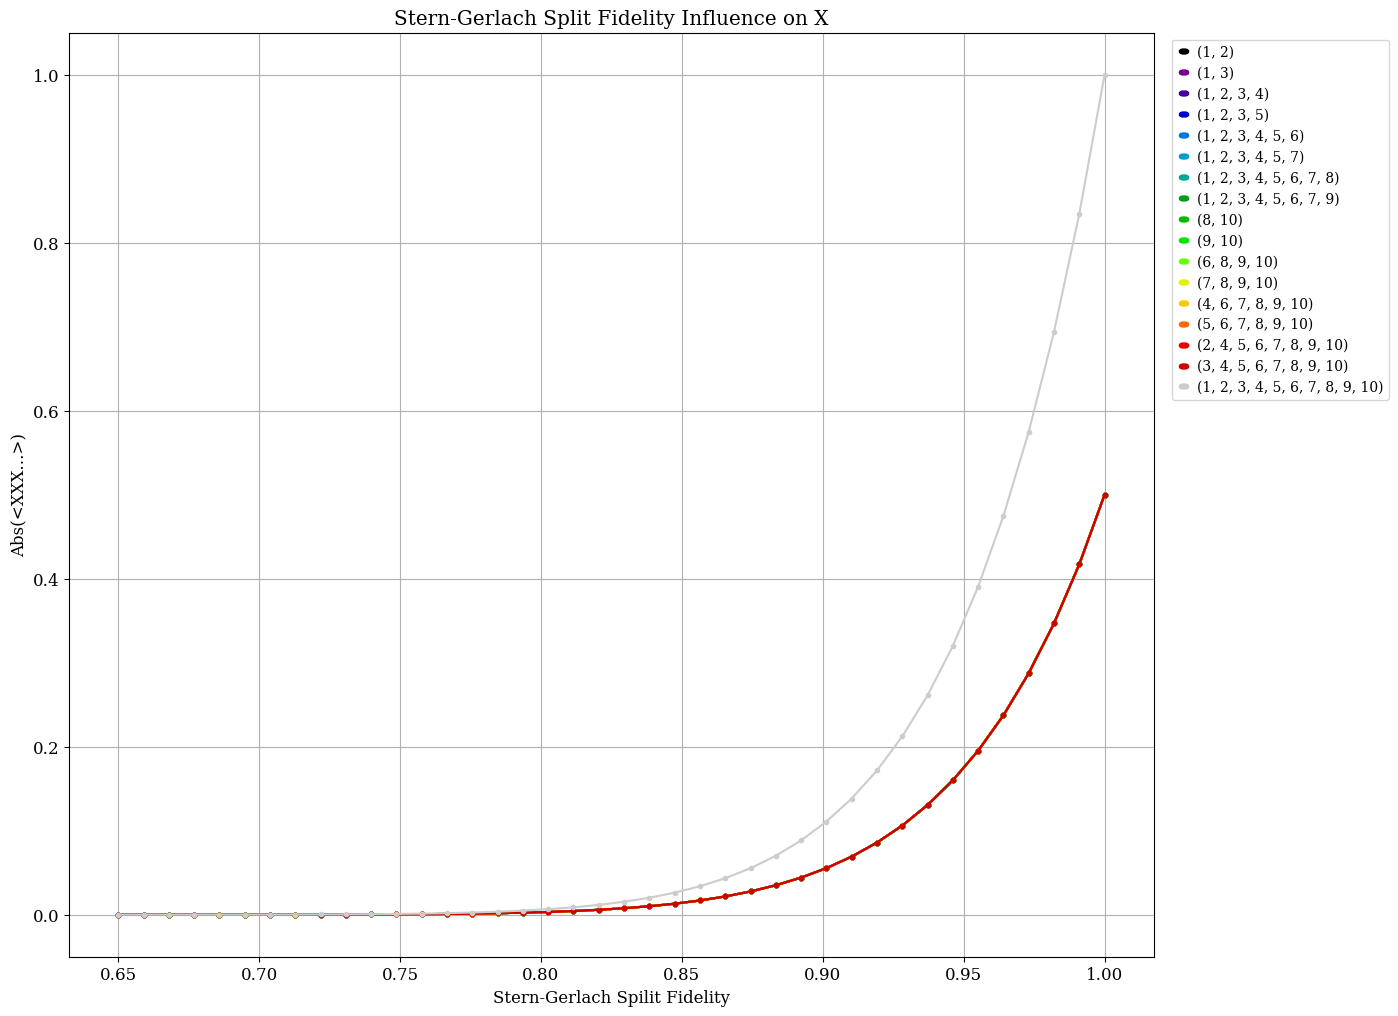

PyObject <matplotlib.legend.Legend object at 0x15bacbd30>

In [80]:
rc("font", family="serif",size=12)

colorlist=Vector(LinRange(0,1,posnum))
figure(figsize=(14,12))

# subplot(2,2,1)
grid()
title("Stern-Gerlach Split Fidelity Influence on X")
for i in 1:posnum
    plot(flist,rexlist[i,:],".-",label=string(tuple(baddrs(usefulposition[i])...)),color=plt.cm.nipy_spectral(colorlist[i]))
end
# legend(loc="best")
xlabel("Stern-Gerlach Spilit Fidelity")
ylabel("Abs(<XXX...>)")
legend(loc="best",fontsize=10,
            bbox_to_anchor=(1.01,1), numpoints=10,handlelength=0.9, handletextpad=0.5)


In [81]:
HY=matrixgate([1/√2 -1im/√2;-1im/√2 1/√2])
rotchainY=chain(16,repeat(HY,1:10))
rotstateY=copy(reg1times10)
apply!(rotstateY,rotchainY)
flist=LinRange(0.65,1,40)
posnum=length(usefulposition)
reylist=zeros((posnum,40))

i=0
for f in flist
    i+=1
    errorspilit=matrixgate([sqrt(f) sqrt(1-f);sqrt(1-f) sqrt(f)])
    spilit=chain(10,repeat(errorspilit,1:10))
    spilitY=copy(rotstateY)
    apply!(spilitY,spilit)
    j=0
    for pos in usefulposition
        j+=1
        position=tuple(baddrs(pos)...)
        gz=fill(Z,length(position))
        reg=copy(spilitY)
        tracestate=reg |> focus!(position...)|> ρ
        reylist[j,i]=expect(KronBlock(gz...),tracestate)    
    end
end

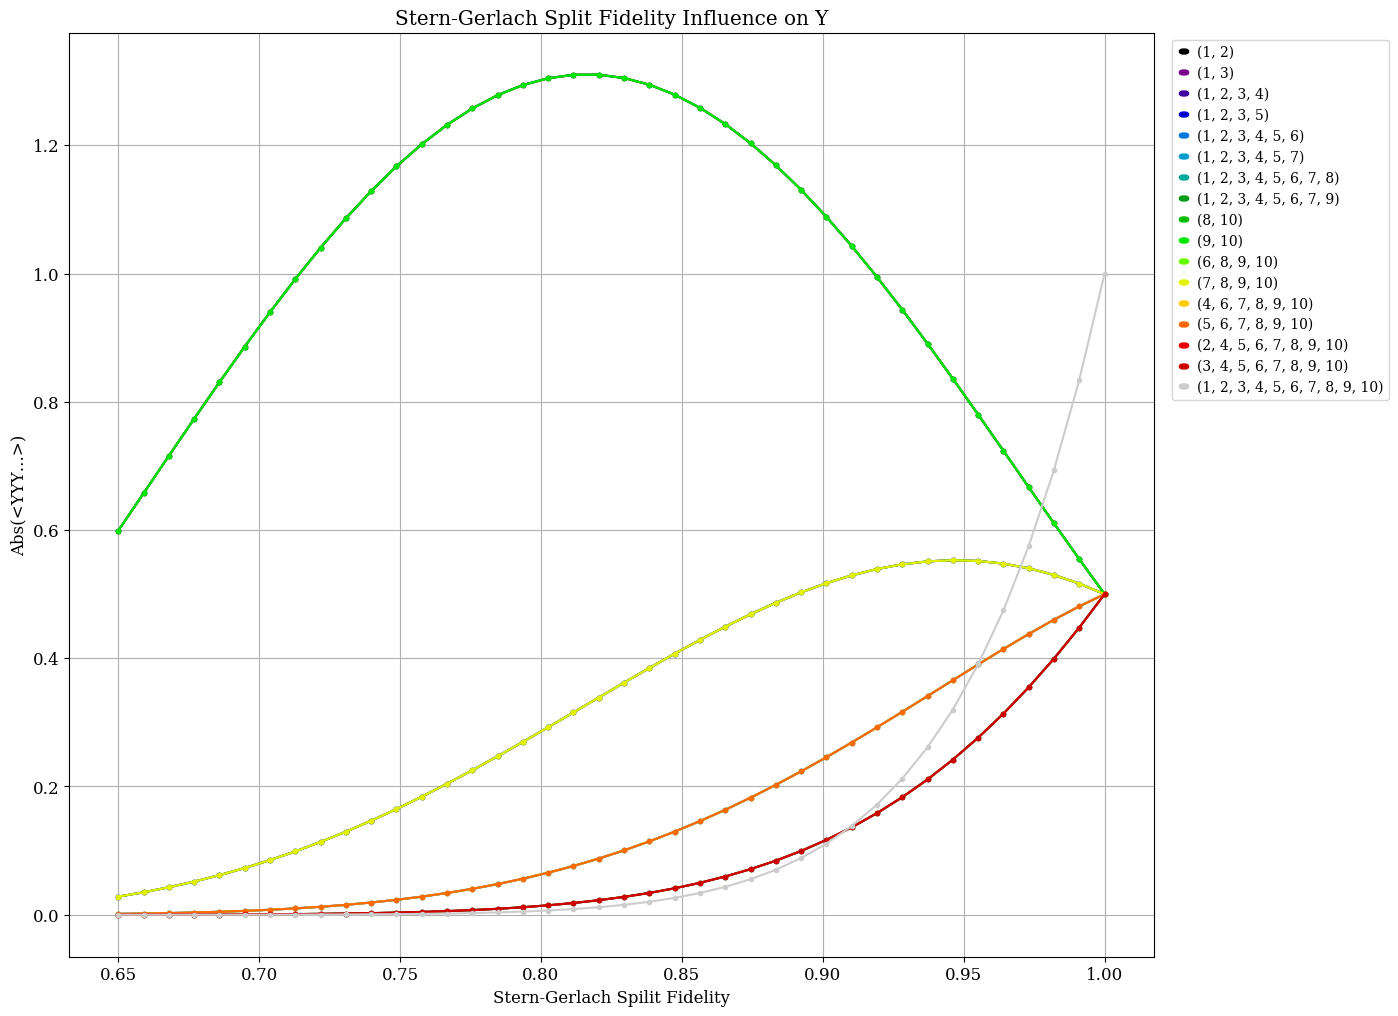

PyObject <matplotlib.legend.Legend object at 0x14d3d5390>

In [82]:
rc("font", family="serif",size=12)

colorlist=Vector(LinRange(0,1,posnum))
figure(figsize=(14,12))

# subplot(2,2,1)
grid()
title("Stern-Gerlach Split Fidelity Influence on Y")
for i in 1:posnum
    plot(flist,reylist[i,:],".-",label=string(tuple(baddrs(usefulposition[i])...)),color=plt.cm.nipy_spectral(colorlist[i]))
end
# legend(loc="best")
xlabel("Stern-Gerlach Spilit Fidelity")
ylabel("Abs(<YYY...>)")
legend(loc="best",fontsize=10,
            bbox_to_anchor=(1.01,1), numpoints=10,handlelength=0.9, handletextpad=0.5)


In [83]:
# HY=matrixgate([1/√2 -1im/√2;-1im/√2 1/√2])
# rotchainY=chain(16,repeat(HY,1:10))
rotstateZ=copy(reg1times10)
# apply!(rotstateY,rotchainY)
flist=LinRange(0.65,1,40)
posnum=length(usefulposition)
rezlist=zeros((posnum,40))

i=0
for f in flist
    i+=1
    errorspilit=matrixgate([sqrt(f) sqrt(1-f);sqrt(1-f) sqrt(f)])
    spilit=chain(10,repeat(errorspilit,1:10))
    spilitZ=copy(rotstateZ)
    apply!(spilitZ,spilit)
    j=0
    for pos in usefulposition
        j+=1
        position=tuple(baddrs(pos)...)
        gz=fill(Z,length(position))
        reg=copy(spilitZ)
        tracestate=reg |> focus!(position...)|> ρ
        rezlist[j,i]=expect(KronBlock(gz...),tracestate)    
    end
end

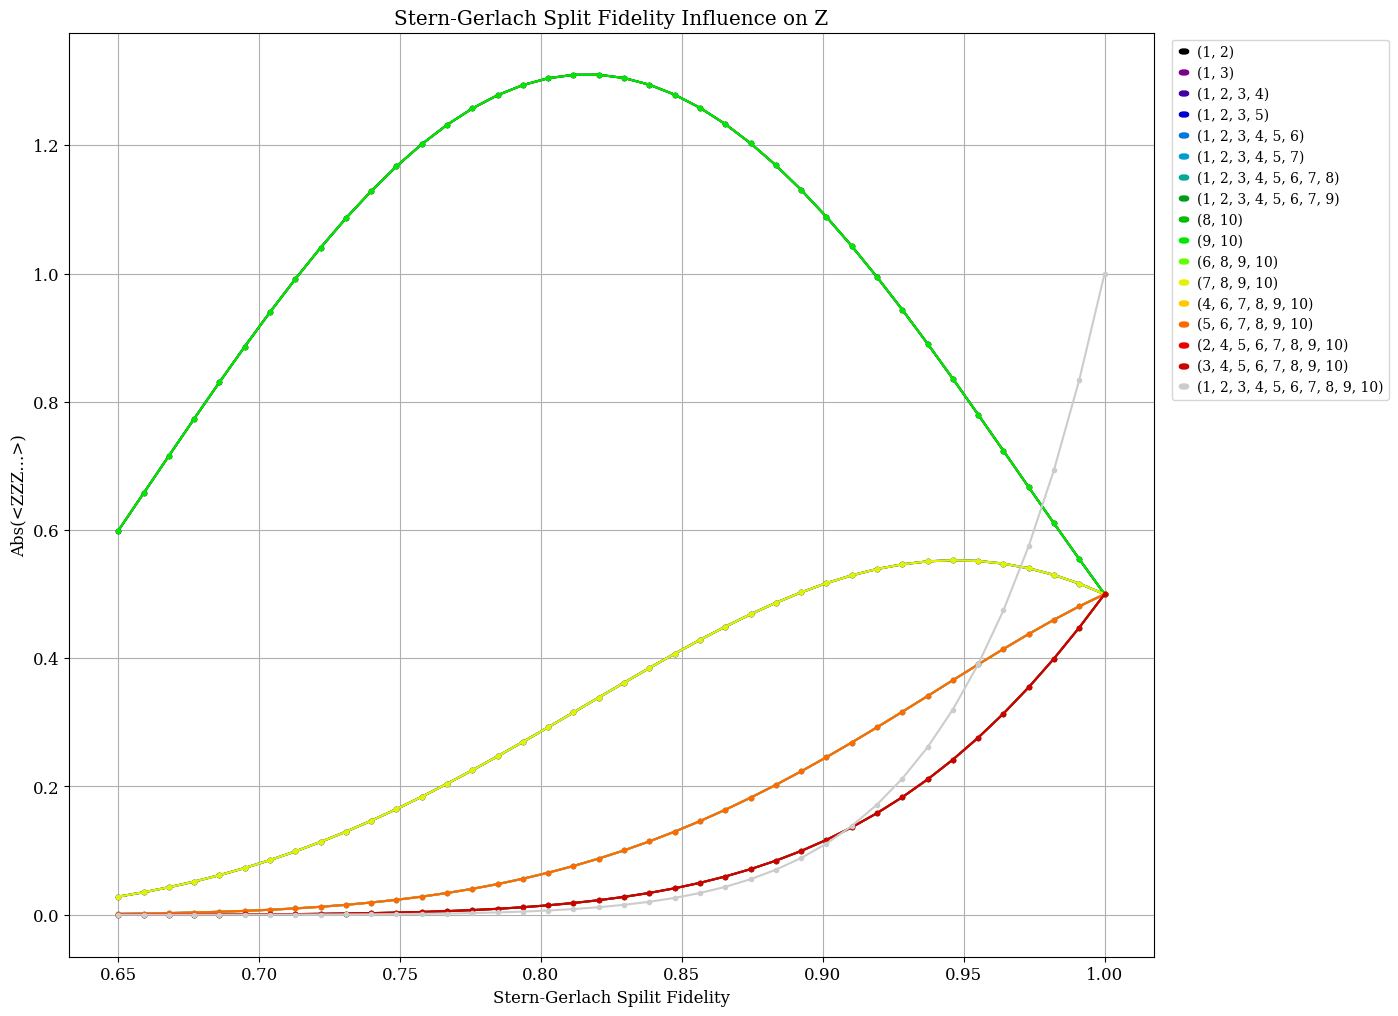

PyObject <matplotlib.legend.Legend object at 0x1518e19e8>

In [84]:
rc("font", family="serif",size=12)

colorlist=Vector(LinRange(0,1,posnum))
figure(figsize=(14,12))

# subplot(2,2,1)
grid()
title("Stern-Gerlach Split Fidelity Influence on Z")
for i in 1:posnum
    plot(flist,abs.(rezlist[i,:]),".-",label=string(tuple(baddrs(usefulposition[i])...)),color=plt.cm.nipy_spectral(colorlist[i]))
end
# legend(loc="best")
xlabel("Stern-Gerlach Spilit Fidelity")
ylabel("Abs(<ZZZ...>)")
legend(loc="best",fontsize=10,
            bbox_to_anchor=(1.01,1), numpoints=10,handlelength=0.9, handletextpad=0.5)


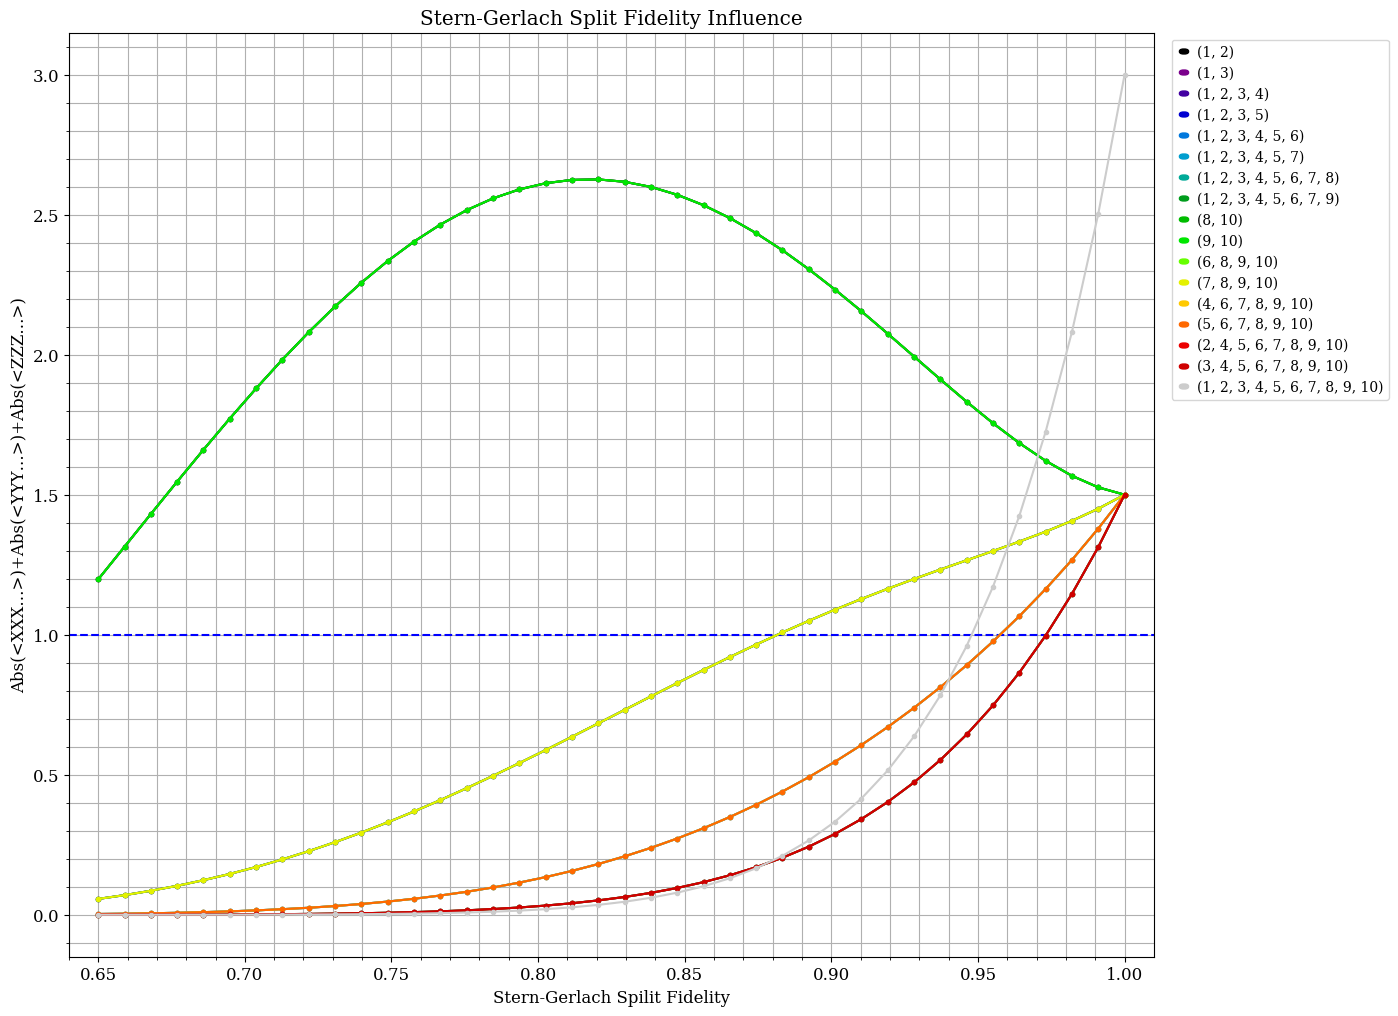

PyObject <matplotlib.legend.Legend object at 0x15af67f28>

In [87]:
rc("font", family="serif",size=12)

colorlist=Vector(LinRange(0,1,posnum))
figure(figsize=(14,12))

# subplot(2,2,1)
grid(which="both")
xlim(0.64,1.01)
minorticks_on()
hlines(1,0,2,colors="blue", linestyles="dashed")
title("Stern-Gerlach Split Fidelity Influence")
for i in 1:posnum
    plot(flist,abs.(rexlist[i,:]).+abs.(reylist[i,:]).+abs.(rezlist[i,:]),".-",label=string(tuple(baddrs(usefulposition[i])...)),color=plt.cm.nipy_spectral(colorlist[i]))
end
# legend(loc="best")
xlabel("Stern-Gerlach Spilit Fidelity")
ylabel("Abs(<XXX...>)+Abs(<YYY...>)+Abs(<ZZZ...>)")
legend(loc="best",fontsize=10,
            bbox_to_anchor=(1.01,1), numpoints=10,handlelength=0.9, handletextpad=0.5)


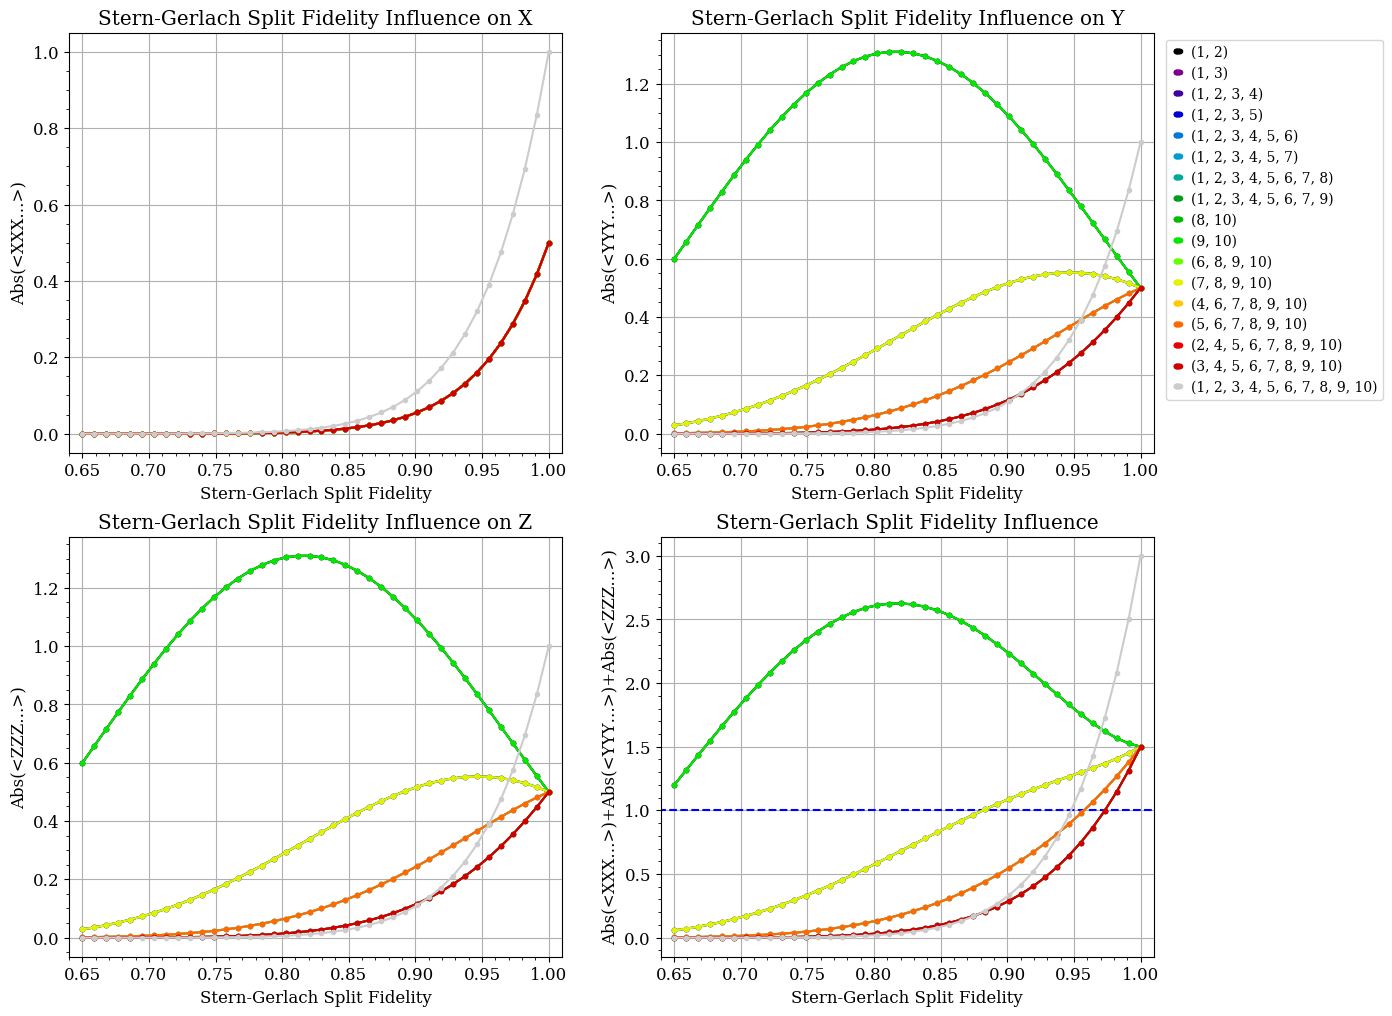

In [89]:
rc("font", family="serif",size=12)

colorlist=Vector(LinRange(0,1,posnum))
figure(figsize=(14,12))

subplot(2,2,1)
grid()
minorticks_on()
xlim(0.64,1.01)
title("Stern-Gerlach Split Fidelity Influence on X")
for i in 1:posnum
    plot(flist,rexlist[i,:],".-",label=string(tuple(baddrs(usefulposition[i])...)),color=plt.cm.nipy_spectral(colorlist[i]))
end
# legend(loc="best")
xlabel("Stern-Gerlach Split Fidelity")
ylabel("Abs(<XXX...>)")
# legend(loc="best",fontsize=10,
#             bbox_to_anchor=(1.01,1), numpoints=10,handlelength=0.9, handletextpad=0.5)


subplot(2,2,2)
grid()
minorticks_on()
xlim(0.64,1.01)
title("Stern-Gerlach Split Fidelity Influence on Y")
for i in 1:posnum
    plot(flist,reylist[i,:],".-",label=string(tuple(baddrs(usefulposition[i])...)),color=plt.cm.nipy_spectral(colorlist[i]))
end
# legend(loc="best")
xlabel("Stern-Gerlach Split Fidelity")
ylabel("Abs(<YYY...>)")
legend(loc="best",fontsize=10,
            bbox_to_anchor=(1.01,1), numpoints=10,handlelength=0.9, handletextpad=0.5)


subplot(2,2,3)
grid()
minorticks_on()
xlim(0.64,1.01)
title("Stern-Gerlach Split Fidelity Influence on Z")
for i in 1:posnum
    plot(flist,abs.(rezlist[i,:]),".-",label=string(tuple(baddrs(usefulposition[i])...)),color=plt.cm.nipy_spectral(colorlist[i]))
end
# legend(loc="best")
xlabel("Stern-Gerlach Split Fidelity")
ylabel("Abs(<ZZZ...>)")
# legend(loc="best",fontsize=10,
#             bbox_to_anchor=(1.01,1), numpoints=10,handlelength=0.9, handletextpad=0.5)


subplot(2,2,4)
grid()
xlim(0.64,1.01)
minorticks_on()
hlines(1,0,2,colors="blue", linestyles="dashed")
title("Stern-Gerlach Split Fidelity Influence")
for i in 1:posnum
    plot(flist,abs.(rexlist[i,:]).+abs.(reylist[i,:]).+abs.(rezlist[i,:]),".-",label=string(tuple(baddrs(usefulposition[i])...)),color=plt.cm.nipy_spectral(colorlist[i]))
end
# legend(loc="best")
xlabel("Stern-Gerlach Split Fidelity")
ylabel("Abs(<XXX...>)+Abs(<YYY...>)+Abs(<ZZZ...>)")
# legend(loc="best",fontsize=10,
#             bbox_to_anchor=(1.01,1), numpoints=10,handlelength=0.9, handletextpad=0.5)

savefig("SternGerlachSplitFidelity.pdf",bbox_inches="tight")